## Define the Convolutional Neural Network

After you've looked at the data you're working with and, in this case, know the shapes of the images and of the keypoints, you are ready to define a convolutional neural network that can *learn* from this data.

In this notebook and in `models.py`, you will:
1. Define a CNN with images as input and keypoints as output
2. Construct the transformed FaceKeypointsDataset, just as before
3. Train the CNN on the training data, tracking loss
4. See how the trained model performs on test data
5. If necessary, modify the CNN structure and model hyperparameters, so that it performs *well* **\***

**\*** What does *well* mean?

"Well" means that the model's loss decreases during training **and**, when applied to test image data, the model produces keypoints that closely match the true keypoints of each face. And you'll see examples of this later in the notebook.

---


## CNN Architecture

Recall that CNN's are defined by a few types of layers:
* Convolutional layers
* Maxpooling layers
* Fully-connected layers

You are required to use the above layers and encouraged to add multiple convolutional layers and things like dropout layers that may prevent overfitting. You are also encouraged to look at literature on keypoint detection, such as [this paper](https://arxiv.org/pdf/1710.00977.pdf), to help you determine the structure of your network.


### TODO: Define your model in the provided file `models.py` file

This file is mostly empty but contains the expected name and some TODO's for creating your model.

---

## PyTorch Neural Nets

To define a neural network in PyTorch, you define the layers of a model in the function `__init__` and define the feedforward behavior of a network that employs those initialized layers in the function `forward`, which takes in an input image tensor, `x`. The structure of this Net class is shown below and left for you to fill in.

Note: During training, PyTorch will be able to perform backpropagation by keeping track of the network's feedforward behavior and using autograd to calculate the update to the weights in the network.

#### Define the Layers in ` __init__`
As a reminder, a conv/pool layer may be defined like this (in `__init__`):
```
# 1 input image channel (for grayscale images), 32 output channels/feature maps, 3x3 square convolution kernel
self.conv1 = nn.Conv2d(1, 32, 3)

# maxpool that uses a square window of kernel_size=2, stride=2
self.pool = nn.MaxPool2d(2, 2)      
```

#### Refer to Layers in `forward`
Then referred to in the `forward` function like this, in which the conv1 layer has a ReLu activation applied to it before maxpooling is applied:
```
x = self.pool(F.relu(self.conv1(x)))
```

Best practice is to place any layers whose weights will change during the training process in `__init__` and refer to them in the `forward` function; any layers or functions that always behave in the same way, such as a pre-defined activation function, should appear *only* in the `forward` function.

#### Why models.py

You are tasked with defining the network in the `models.py` file so that any models you define can be saved and loaded by name in different notebooks in this project directory. For example, by defining a CNN class called `Net` in `models.py`, you can then create that same architecture in this and other notebooks by simply importing the class and instantiating a model:
```
    from models import Net
    net = Net()
```

In [1]:
# load the data if you need to; if you have already loaded the data, you may comment this cell out
# -- DO NOT CHANGE THIS CELL -- #
# !mkdir /data
# !wget -P /data/ https://s3.amazonaws.com/video.udacity-data.com/topher/2018/May/5aea1b91_train-test-data/train-test-data.zip
# !unzip /data/train-test-data.zip -d /data

<div class="alert alert-info">**Note:** Workspaces preserve your available GPU time by closing the connection after 30 minutes of inactivity (including inactivity while training!). Use the code snippet below to keep your workspace alive during training.
</div>

In [2]:
import requests
response = requests.request("GET", "http://metadata.google.internal/computeMetadata/v1/instance/attributes/keep_alive_token", headers={"Metadata-Flavor":"Google"})
token = response.text

# add the next line to run in each iteration of your main training loop
# requests.request("POST", "https://nebula.udacity.com/api/v1/remote/keep-alive", headers={'Authorization': "STAR " + token})
requests.request("POST", "https://nebula.udacity.com/api/v1/remote/keep-alive", headers={'Authorization': "STAR " + token})

<Response [200]>

In [3]:
# import the usual resources
import matplotlib.pyplot as plt
import numpy as np

# watch for any changes in model.py, if it changes, re-load it automatically
%load_ext autoreload
%autoreload 2

In [4]:
## TODO: Define the Net in models.py

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
## TODO: Once you've define the network, you can instantiate it
# one example conv layer has been provided for you
from models import *

net = AlexNet()
print(net)

AlexNet(
  (conv1): Conv2d(1, 96, kernel_size=(4, 4), stride=(4, 4))
  (conv2): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
  (fc1): Linear(in_features=9216, out_features=4096, bias=True)
  (fc2): Linear(in_features=4096, out_features=4096, bias=True)
  (fc3): Linear(in_features=4096, out_features=136, bias=True)
  (dropout2): Dropout(p=0.2)
  (dropout4): Dropout(p=0.4)
  (dropout6): Dropout(p=0.6)
  (bn1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True)
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
  (bn3): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True)
  (bn4): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=

## Transform the dataset 

To prepare for training, create a transformed dataset of images and keypoints.

### TODO: Define a data transform

In PyTorch, a convolutional neural network expects a torch image of a consistent size as input. For efficient training, and so your model's loss does not blow up during training, it is also suggested that you normalize the input images and keypoints. The necessary transforms have been defined in `data_load.py` and you **do not** need to modify these; take a look at this file (you'll see the same transforms that were defined and applied in Notebook 1).

To define the data transform below, use a [composition](http://pytorch.org/tutorials/beginner/data_loading_tutorial.html#compose-transforms) of:
1. Rescaling and/or cropping the data, such that you are left with a square image (the suggested size is 224x224px)
2. Normalizing the images and keypoints; turning each RGB image into a grayscale image with a color range of [0, 1] and transforming the given keypoints into a range of [-1, 1]
3. Turning these images and keypoints into Tensors

These transformations have been defined in `data_load.py`, but it's up to you to call them and create a `data_transform` below. **This transform will be applied to the training data and, later, the test data**. It will change how you go about displaying these images and keypoints, but these steps are essential for efficient training.

As a note, should you want to perform data augmentation (which is optional in this project), and randomly rotate or shift these images, a square image size will be useful; rotating a 224x224 image by 90 degrees will result in the same shape of output.

In [5]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# the dataset we created in Notebook 1 is copied in the helper file `data_load.py`
from data_load import FacialKeypointsDataset
# the transforms we defined in Notebook 1 are in the helper file `data_load.py`
from data_load import Rescale, RandomCrop, Normalize, ToTensor

# Perform data augmentation on train dataset by first scaling and then random cropping
train_data_transform = transforms.Compose([Rescale((250, 250)), \
                                           RandomCrop((227, 227)), \
                                           Normalize(), \
                                           ToTensor()])

test_data_transform = transforms.Compose([Rescale((227, 227)), \
                                          Normalize(), \
                                          ToTensor()])

In [6]:
transformed_dataset = FacialKeypointsDataset(csv_file='/data/training_frames_keypoints.csv',
                                             root_dir='/data/training/',
                                             transform=train_data_transform)

print('Number of images: ', len(transformed_dataset))

# iterate through the transformed dataset and print some stats about the first few samples
for i in range(4):
    sample = transformed_dataset[i]
    print(i, sample['image'].size(), sample['keypoints'].size())

Number of images:  3462
0 torch.Size([1, 227, 227]) torch.Size([68, 2])
1 torch.Size([1, 227, 227]) torch.Size([68, 2])
2 torch.Size([1, 227, 227]) torch.Size([68, 2])
3 torch.Size([1, 227, 227]) torch.Size([68, 2])


## Batching and loading data

Next, having defined the transformed dataset, we can use PyTorch's DataLoader class to load the training data in batches of whatever size as well as to shuffle the data for training the model. You can read more about the parameters of the DataLoader, in [this documentation](http://pytorch.org/docs/master/data.html).

#### Batch size
Decide on a good batch size for training your model. Try both small and large batch sizes and note how the loss decreases as the model trains.

**Note for Windows users**: Please change the `num_workers` to 0 or you may face some issues with your DataLoader failing.

In [7]:
# load training data in batches
batch_size = 10

train_loader = DataLoader(transformed_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=4)


## Before training

Take a look at how this model performs before it trains. You should see that the keypoints it predicts start off in one spot and don't match the keypoints on a face at all! It's interesting to visualize this behavior so that you can compare it to the model after training and see how the model has improved.

#### Load in the test dataset

The test dataset is one that this model has *not* seen before, meaning it has not trained with these images. We'll load in this test data and before and after training, see how your model performs on this set!

To visualize this test data, we have to go through some un-transformation steps to turn our images into python images from tensors and to turn our keypoints back into a recognizable range. 

In [8]:
test_dataset = FacialKeypointsDataset(csv_file='/data/test_frames_keypoints.csv',
                                             root_dir='/data/test/',
                                             transform=test_data_transform)

In [9]:
# load test data in batches
batch_size = 10

test_loader = DataLoader(test_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=4)

## Apply the model on a test sample

To test the model on a test sample of data, you have to follow these steps:
1. Extract the image and ground truth keypoints from a sample
2. Wrap the image in a Variable, so that the net can process it as input and track how it changes as the image moves through the network.
3. Make sure the image is a FloatTensor, which the model expects.
4. Forward pass the image through the net to get the predicted, output keypoints.

This function test how the network performs on the first batch of test data. It returns the images, the transformed images, the predicted keypoints (produced by the model), and the ground truth keypoints.

In [10]:
# test the model on a batch of test images

def net_sample_output():
    net.eval()
    # iterate through the test dataset
    for i, sample in enumerate(test_loader):
        
        # get sample data: images and ground truth keypoints
        images = sample['image']
        key_pts = sample['keypoints']
        
#         print("key_pts.shape:", key_pts.shape)
        # key_pts do not need to be wrapped until they are used for training
        images = Variable(images, volatile=True)

        # convert images to FloatTensors
        images = images.type(torch.FloatTensor)

        # forward pass to get net output
        output_pts = net.forward(images)
#     output_pts = net.forward(Variable(roi, volatile=True))
#         print("output_pts.size():", output_pts.size())
        # reshape to batch_size x 68 x 2 pts
        output_pts = output_pts.view(output_pts.size()[0], 68, -1)
    
        # break after first image is tested
        if i == 0:
            return images, output_pts, key_pts
            

#### Debugging tips

If you get a size or dimension error here, make sure that your network outputs the expected number of keypoints! Or if you get a Tensor type error, look into changing the above code that casts the data into float types: `images = images.type(torch.FloatTensor)`.

In [11]:
# call the above function
# returns: test images, test predicted keypoints, test ground truth keypoints
test_images, test_outputs, gt_pts = net_sample_output()

# print out the dimensions of the data to see if they make sense
print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

torch.Size([10, 1, 227, 227])
torch.Size([10, 68, 2])
torch.Size([10, 68, 2])


In [12]:
gt_pts


(0 ,.,.) = 
 -0.3099  0.1883
 -0.3099  0.3517
 -0.3099  0.5476
       ⋮        
  0.6180  0.6783
  0.5517  0.6783
  0.4523  0.6783

(1 ,.,.) = 
 -0.8735 -0.0217
 -0.8735  0.1559
 -0.8394  0.3334
       ⋮        
  0.2529  0.4349
  0.1505  0.4349
  0.0140  0.4349

(2 ,.,.) = 
 -0.7269  0.0010
 -0.7269  0.2162
 -0.7269  0.4314
       ⋮        
  0.0898  0.7756
 -0.0303  0.7756
 -0.1023  0.7756
...

(7 ,.,.) = 
 -0.4209 -0.4930
 -0.4209 -0.2069
 -0.4209  0.0792
       ⋮        
  0.3687  0.5752
  0.2536  0.5180
  0.1220  0.5180

(8 ,.,.) = 
 -0.4209  0.0602
 -0.3419  0.2891
 -0.3024  0.4798
       ⋮        
  0.5266  0.7850
  0.4871  0.8232
  0.3687  0.8232

(9 ,.,.) = 
 -0.3816 -0.0413
 -0.3816  0.2051
 -0.3816  0.3867
       ⋮        
  0.5636  0.6981
  0.5206  0.6981
  0.4633  0.6981
[torch.DoubleTensor of size 10x68x2]

In [13]:
test_outputs.data


(0 ,.,.) = 
1.00000e-02 *
 -0.7116  0.6448
 -0.1422 -1.0321
  0.3765 -0.5480
       ⋮        
 -0.2885 -0.9201
 -2.1231  1.9411
  0.5732 -1.8064

(1 ,.,.) = 
1.00000e-02 *
 -0.4074  0.5215
 -0.0893 -0.8423
  0.4470 -0.5682
       ⋮        
  0.1195 -0.9931
 -2.1351  1.5391
  0.8118 -1.3764

(2 ,.,.) = 
1.00000e-02 *
 -0.5538  0.5660
  0.0181 -0.9224
  0.3886 -0.6677
       ⋮        
 -0.1703 -0.9863
 -2.1205  1.5540
  0.5032 -1.4834
...

(7 ,.,.) = 
1.00000e-02 *
 -0.4701  0.5921
 -0.1084 -1.0564
  0.3763 -0.5418
       ⋮        
 -0.0975 -0.9035
 -2.0569  1.6955
  0.6670 -1.5599

(8 ,.,.) = 
1.00000e-02 *
 -0.4559  0.5487
 -0.1471 -0.9284
  0.3960 -0.6661
       ⋮        
  0.0772 -1.0223
 -2.1110  1.7593
  0.5421 -1.5025

(9 ,.,.) = 
1.00000e-02 *
 -0.3874  0.5004
 -0.0947 -0.9186
  0.4740 -0.5823
       ⋮        
  0.2162 -1.0613
 -2.3482  1.6559
  0.8479 -1.5111
[torch.FloatTensor of size 10x68x2]

## Visualize the predicted keypoints

Once we've had the model produce some predicted output keypoints, we can visualize these points in a way that's similar to how we've displayed this data before, only this time, we have to "un-transform" the image/keypoint data to display it.

Note that I've defined a *new* function, `show_all_keypoints` that displays a grayscale image, its predicted keypoints and its ground truth keypoints (if provided).

In [14]:
def show_all_keypoints(image, predicted_key_pts, gt_pts=None):
    """Show image with predicted keypoints"""
    # image is grayscale
    plt.imshow(image, cmap='gray')
    plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=20, marker='.', c='m')
    # plot ground truth points as green pts
    if gt_pts is not None:
        plt.scatter(gt_pts[:, 0], gt_pts[:, 1], s=20, marker='.', c='g')


#### Un-transformation

Next, you'll see a helper function. `visualize_output` that takes in a batch of images, predicted keypoints, and ground truth keypoints and displays a set of those images and their true/predicted keypoints.

This function's main role is to take batches of image and keypoint data (the input and output of your CNN), and transform them into numpy images and un-normalized keypoints (x, y) for normal display. The un-transformation process turns keypoints and images into numpy arrays from Tensors *and* it undoes the keypoint normalization done in the Normalize() transform; it's assumed that you applied these transformations when you loaded your test data.

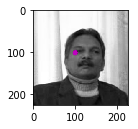

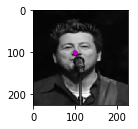

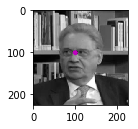

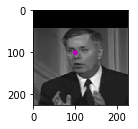

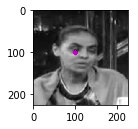

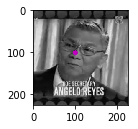

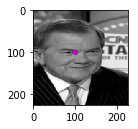

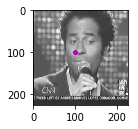

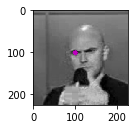

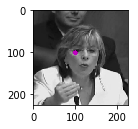

In [15]:
# visualize the output
# by default this shows a batch of 10 images
def visualize_output(test_images, test_outputs, gt_pts=None, batch_size=10):
    
#     net.eval()
    
    for i in range(batch_size):
        plt.figure(figsize=(20,10))
        ax = plt.subplot(1, batch_size, i+1)

        # un-transform the image data
        image = test_images[i].data   # get the image from it's Variable wrapper
        image = image.numpy()   # convert to numpy array from a Tensor
        image = np.transpose(image, (1, 2, 0))   # transpose to go from torch to numpy image

        # un-transform the predicted key_pts data
        predicted_key_pts = test_outputs[i].data
        predicted_key_pts = predicted_key_pts.numpy()
                
        # undo normalization of keypoints  
        predicted_key_pts = predicted_key_pts*50.0+100
#         predicted_key_pts = (predicted_key_pts * 48.0) + 48
    
        # plot ground truth points for comparison, if they exist
        ground_truth_pts = None
        if gt_pts is not None:
            ground_truth_pts = gt_pts[i]         
            ground_truth_pts = ground_truth_pts*50.0+100
#             ground_truth_pts = (ground_truth_pts * 48.0) + 48
    
        # call show_all_keypoints
        show_all_keypoints(np.squeeze(image), predicted_key_pts, ground_truth_pts)
        
#         plt.axis('off')
    
    
    plt.show()
    
# call it
# visualize_output(test_images, test_outputs, gt_pts)
visualize_output(test_images, test_outputs, gt_pts=None)

## Training

#### Loss function
Training a network to predict keypoints is different than training a network to predict a class; instead of outputting a distribution of classes and using cross entropy loss, you may want to choose a loss function that is suited for regression, which directly compares a predicted value and target value. Read about the various kinds of loss functions (like MSE or L1/SmoothL1 loss) in [this documentation](http://pytorch.org/docs/master/_modules/torch/nn/modules/loss.html).

### TODO: Define the loss and optimization

Next, you'll define how the model will train by deciding on the loss function and optimizer.

---

In [16]:
import torch.optim as optim

# criterion = nn.MSELoss()
criterion = nn.SmoothL1Loss()

optimizer = optim.Adam(net.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08)


## Training and Initial Observation

Now, you'll train on your batched training data from `train_loader` for a number of epochs. 

To quickly observe how your model is training and decide on whether or not you should modify it's structure or hyperparameters, you're encouraged to start off with just one or two epochs at first. As you train, note how your the model's loss behaves over time: does it decrease quickly at first and then slow down? Does it take a while to decrease in the first place? What happens if you change the batch size of your training data or modify your loss function? etc. 

Use these initial observations to make changes to your model and decide on the best architecture before you train for many epochs and create a final model.

In [17]:
def train_net(n_epochs):

    # Model in training mode, dropout is on
    net.train()

    for epoch in range(n_epochs):  # loop over the dataset multiple times
        
        requests.request("POST", "https://nebula.udacity.com/api/v1/remote/keep-alive", headers={'Authorization': "STAR " + token})
        
        running_loss = 0.0

        # train on batches of data, assumes you already have train_loader
        for batch_i, data in enumerate(train_loader):
            requests.request("POST", "https://nebula.udacity.com/api/v1/remote/keep-alive", headers={'Authorization': "STAR " + token})
            
            # get the input images and their corresponding labels
            images = data['image']
            key_pts = data['keypoints']

            # flatten pts
            key_pts = key_pts.view(key_pts.size(0), -1)
            
            # wrap them in a torch Variable
            images, key_pts = Variable(images), Variable(key_pts)

            # convert variables to floats for regression loss
            key_pts = key_pts.type(torch.FloatTensor)
            images = images.type(torch.FloatTensor)

            # forward pass to get outputs
            output_pts = net.forward(images)

            # calculate the loss between predicted and target keypoints
            loss = criterion(output_pts, key_pts)

            # zero the parameter (weight) gradients
            optimizer.zero_grad()
            
            # backward pass to calculate the weight gradients
            loss.backward()

            # update the weights
            optimizer.step()

            # print loss statistics
            running_loss += loss.data[0]
#             if batch_i % 10 == 9:    # print every 10 batches
#                 print('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(epoch + 1, batch_i+1, running_loss/10)) 
#                 running_loss = 0.0
            if batch_i % 40 == 39:    # print every 40 batches
                print('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(epoch + 1, batch_i + 1, running_loss / 40)) 
                running_loss = 0.0

    print('Finished Training')


In [18]:
# train your network
n_epochs = 50 # start small, and increase when you've decided on your model structure and hyperparams

train_net(n_epochs)

Epoch: 1, Batch: 40, Avg. Loss: 0.6326374568045139
Epoch: 1, Batch: 80, Avg. Loss: 0.446803979575634
Epoch: 1, Batch: 120, Avg. Loss: 0.3885910890996456
Epoch: 1, Batch: 160, Avg. Loss: 0.3587844602763653
Epoch: 1, Batch: 200, Avg. Loss: 0.3477230750024319
Epoch: 1, Batch: 240, Avg. Loss: 0.3263415336608887
Epoch: 1, Batch: 280, Avg. Loss: 0.30603612661361695
Epoch: 1, Batch: 320, Avg. Loss: 0.2987467348575592
Epoch: 2, Batch: 40, Avg. Loss: 0.27451503537595273
Epoch: 2, Batch: 80, Avg. Loss: 0.2624157160520554
Epoch: 2, Batch: 120, Avg. Loss: 0.25318072363734245
Epoch: 2, Batch: 160, Avg. Loss: 0.23066340051591397
Epoch: 2, Batch: 200, Avg. Loss: 0.22369418628513812
Epoch: 2, Batch: 240, Avg. Loss: 0.2183464527130127
Epoch: 2, Batch: 280, Avg. Loss: 0.20379850268363953
Epoch: 2, Batch: 320, Avg. Loss: 0.19480350092053414
Epoch: 3, Batch: 40, Avg. Loss: 0.18122272305190562
Epoch: 3, Batch: 80, Avg. Loss: 0.176811695471406
Epoch: 3, Batch: 120, Avg. Loss: 0.1790431972593069
Epoch: 3, Ba

Epoch: 20, Batch: 120, Avg. Loss: 0.02183644794858992
Epoch: 20, Batch: 160, Avg. Loss: 0.024356749816797675
Epoch: 20, Batch: 200, Avg. Loss: 0.02255848494824022
Epoch: 20, Batch: 240, Avg. Loss: 0.02169012709055096
Epoch: 20, Batch: 280, Avg. Loss: 0.02160650920122862
Epoch: 20, Batch: 320, Avg. Loss: 0.01870574118802324
Epoch: 21, Batch: 40, Avg. Loss: 0.022611109493300318
Epoch: 21, Batch: 80, Avg. Loss: 0.022337097860872745
Epoch: 21, Batch: 120, Avg. Loss: 0.016479682573117316
Epoch: 21, Batch: 160, Avg. Loss: 0.0183877089060843
Epoch: 21, Batch: 200, Avg. Loss: 0.019071675697341563
Epoch: 21, Batch: 240, Avg. Loss: 0.017790734372101723
Epoch: 21, Batch: 280, Avg. Loss: 0.020181661448441447
Epoch: 21, Batch: 320, Avg. Loss: 0.019244080560747535
Epoch: 22, Batch: 40, Avg. Loss: 0.0202589831314981
Epoch: 22, Batch: 80, Avg. Loss: 0.017050753231160343
Epoch: 22, Batch: 120, Avg. Loss: 0.020949657750315966
Epoch: 22, Batch: 160, Avg. Loss: 0.020269973925314842
Epoch: 22, Batch: 200, 

Epoch: 39, Batch: 80, Avg. Loss: 0.01138499598018825
Epoch: 39, Batch: 120, Avg. Loss: 0.010599864542018621
Epoch: 39, Batch: 160, Avg. Loss: 0.0113132081925869
Epoch: 39, Batch: 200, Avg. Loss: 0.015021705604158341
Epoch: 39, Batch: 240, Avg. Loss: 0.012720953836105765
Epoch: 39, Batch: 280, Avg. Loss: 0.013986544392537326
Epoch: 39, Batch: 320, Avg. Loss: 0.01072256063343957
Epoch: 40, Batch: 40, Avg. Loss: 0.010457567521370947
Epoch: 40, Batch: 80, Avg. Loss: 0.00986303526442498
Epoch: 40, Batch: 120, Avg. Loss: 0.011041143094189465
Epoch: 40, Batch: 160, Avg. Loss: 0.01215987007599324
Epoch: 40, Batch: 200, Avg. Loss: 0.012639662006404252
Epoch: 40, Batch: 240, Avg. Loss: 0.009884601621888579
Epoch: 40, Batch: 280, Avg. Loss: 0.012418499891646206
Epoch: 40, Batch: 320, Avg. Loss: 0.011812056496273727
Epoch: 41, Batch: 40, Avg. Loss: 0.011227052984759211
Epoch: 41, Batch: 80, Avg. Loss: 0.011333405505865812
Epoch: 41, Batch: 120, Avg. Loss: 0.012317894387524574
Epoch: 41, Batch: 160

## Test data

See how your model performs on previously unseen, test data. We've already loaded and transformed this data, similar to the training data. Next, run your trained model on these images to see what kind of keypoints are produced. You should be able to see if your model is fitting each new face it sees, if the points are distributed randomly, or if the points have actually overfitted the training data and do not generalize.

In [19]:
# get a sample of test data again
test_images, test_outputs, gt_pts = net_sample_output()

print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

torch.Size([10, 1, 227, 227])
torch.Size([10, 68, 2])
torch.Size([10, 68, 2])


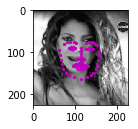

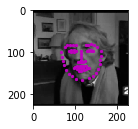

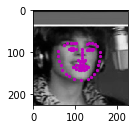

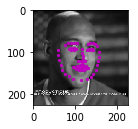

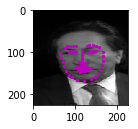

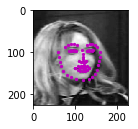

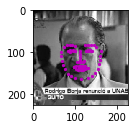

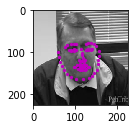

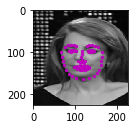

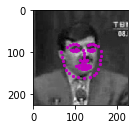

In [20]:
## TODO: visualize your test output
# you can use the same function as before, by un-commenting the line below:

visualize_output(test_images, test_outputs, gt_pts=None)


Once you've found a good model (or two), save your model so you can load it and use it later!

Save your models but please **delete any checkpoints and saved models before you submit your project** otherwise your workspace may be too large to submit.

In [21]:
## TODO: change the name to something uniqe for each new model
model_dir = 'saved_models/'
model_name = 'keypoints_model_AlexNet_50epochs.pth'

# after training, save your model parameters in the dir 'saved_models'
torch.save(net.state_dict(), model_dir+model_name)

After you've trained a well-performing model, answer the following questions so that we have some insight into your training and architecture selection process. Answering all questions is required to pass this project.

### Question 1: What optimization and loss functions did you choose and why?


<u><b>Optimization</b></u>: I used Adam (Adaptive momentum estimation, 2015) with learning rate of 0.001, $B_1$ (1st moment) of 0.9, $B_2$ (2nd moment) of 0.999 and $\epsilon$ of 1e-08. <br>

<ul>
    <li>$B_1$ of 0.9 allows us to average over the last $\dfrac{1}{1-\beta} = 10$ iterations of gradient, and controls the exponentially weighted average. <br>
    </li>
    <li>$B_2$ comes from RMSpop (Root Mean Square Propagation) that helps tackling the oscillations. <br>
    </li>
    <li>$\epsilon$ is to make sure that the RMSprop part doesn't divide by 0. Hence, to ensure numerical stability, when implementing this in practice, you add a very small epsilon
    </li>
</ul>

<u><b>Loss</b></u>: The outputs we are looking for are the coordinated (x, y) of the 68 keypoints of a face, coordinates are continuous values and therefore we have a regression problem. 
<ul>
    <li>The Mean Squared error is a great loss function as it penalize more big errors. I first used that but noticed that the loss was excessively too high at some times</li>
    <li>To address the high loss, I opted for the `SmoothL1Loss` which is also known as the Huber Loss, it creates a criterion that uses a squared term if the absolute
    element-wise error falls below 1 and an L1 term otherwise.
    It is less sensitive to outliers than the `MSELoss` and in some cases
        prevents exploding gradients 
    </li>
</ul>

### Question 2: What kind of network architecture did you start with and how did it change as you tried different architectures? Did you decide to add more convolutional layers or any layers to avoid overfitting the data?

I used Naimish architecture from the paper `Facial Key Points Detection using Deep Convolutional Neural Network, 2017`. The only I changed was the last 2 dense layers as I did not understand why making 1000 nodes to 1000 nodes was particularly interesting and the output is 136 values in this problem.

### Question 3: How did you decide on the number of epochs and batch_size to train your model?

I set the # of epochs to be 5 as it seemed to give accurate results at this point. <br>
The batch_size of 10 is enough as for each epoch we iterate over the data 320 times to update the gradients. 

## Feature Visualization

Sometimes, neural networks are thought of as a black box, given some input, they learn to produce some output. CNN's are actually learning to recognize a variety of spatial patterns and you can visualize what each convolutional layer has been trained to recognize by looking at the weights that make up each convolutional kernel and applying those one at a time to a sample image. This technique is called feature visualization and it's useful for understanding the inner workings of a CNN.

In the cell below, you can see how to extract a single filter (by index) from your first convolutional layer. The filter should appear as a grayscale grid.

[[ 0.18726508  0.11221232  0.10663381  0.08762775]
 [-0.08760897 -0.07851646 -0.01777102 -0.09935877]
 [-0.08140551 -0.14740786 -0.14350808 -0.13550848]
 [-0.1073745  -0.10763909 -0.10008214 -0.0367885 ]]
(4, 4)


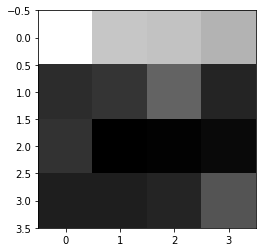

In [22]:
# Get the weights in the first conv layer, "conv1"
# if necessary, change this to reflect the name of your first conv layer
weights1 = net.conv1.weight.data

w = weights1.numpy()

filter_index = 0

print(w[filter_index][0])
print(w[filter_index][0].shape)

# display the filter weights
plt.imshow(w[filter_index][0], cmap='gray')


## Feature maps

Each CNN has at least one convolutional layer that is composed of stacked filters (also known as convolutional kernels). As a CNN trains, it learns what weights to include in it's convolutional kernels and when these kernels are applied to some input image, they produce a set of **feature maps**. So, feature maps are just sets of filtered images; they are the images produced by applying a convolutional kernel to an input image. These maps show us the features that the different layers of the neural network learn to extract. For example, you might imagine a convolutional kernel that detects the vertical edges of a face or another one that detects the corners of eyes. You can see what kind of features each of these kernels detects by applying them to an image. One such example is shown below; from the way it brings out the lines in an the image, you might characterize this as an edge detection filter.

<img src='images/feature_map_ex.png' width=50% height=50%/>


Next, choose a test image and filter it with one of the convolutional kernels in your trained CNN; look at the filtered output to get an idea what that particular kernel detects.

### TODO: Filter an image to see the effect of a convolutional kernel
---

[[ 0.18726508  0.11221232  0.10663381  0.08762775]
 [-0.08760897 -0.07851646 -0.01777102 -0.09935877]
 [-0.08140551 -0.14740786 -0.14350808 -0.13550848]
 [-0.1073745  -0.10763909 -0.10008214 -0.0367885 ]]
(4, 4)


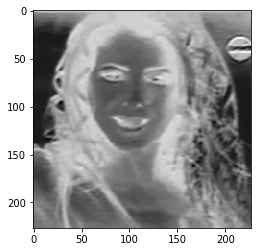

In [23]:
import cv2
##TODO: load in and display any image from the transformed test dataset

## TODO: Using cv's filter2D function,
## apply a specific set of filter weights (like the one displayed above) to the test image

weights1 = net.conv1.weight.data

w = weights1.numpy()

filter_index = 0

print(w[filter_index][0])
print(w[filter_index][0].shape)

# display the filter weights
# plt.imshow(w[filter_index][0], cmap='gray')


idx_img = 0
img = np.squeeze(test_images[idx_img].data.numpy())

# plt.imshow(img, cmap="gray")

filtered_img = cv2.filter2D(img, -1, w[filter_index][0])
plt.imshow(filtered_img, cmap="gray")

### Question 4: Choose one filter from your trained CNN and apply it to a test image; what purpose do you think it plays? What kind of feature do you think it detects?


The filter seems to blur out noise

---
## Moving on!

Now that you've defined and trained your model (and saved the best model), you are ready to move on to the last notebook, which combines a face detector with your saved model to create a facial keypoint detection system that can predict the keypoints on *any* face in an image!